Deep Learning
=============

Assignment 6
------------

After training a skip-gram model in `5_word2vec.ipynb`, the goal of this notebook is to train a LSTM character model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [3]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import os
import numpy as np
import random
import string
import tensorflow as tf
import zipfile
from six.moves import range
from six.moves.urllib.request import urlretrieve
from IPython.display import clear_output

from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


In [5]:
def read_data(filename):
  with zipfile.ZipFile(filename) as f:
    name = f.namelist()[0]
    data = tf.compat.as_str(f.read(name))
  return data
  
text = read_data(filename)
print('Data size %d' % len(text))

Data size 100000000


Create a small validation set.

In [4]:
valid_size = 1000
valid_text = text[:valid_size]
train_text = text[valid_size:]
train_size = len(train_text)
print(train_size, train_text[:64])
print(valid_size, valid_text[:64])

99999000 ons anarchists advocate social relations based upon voluntary as
1000  anarchism originated as a term of abuse first used against earl


Utility functions to map characters to vocabulary IDs and back.

In [5]:
vocabulary_size = len(string.ascii_lowercase) + 1 # [a-z] + ' '
first_letter = ord(string.ascii_lowercase[0])

def char2id(char):
  if char in string.ascii_lowercase:
    return ord(char) - first_letter + 1
  elif char == ' ':
    return 0
  else:
    print('Unexpected character: %s' % char)
    return 0
  
def id2char(dictid):
  if dictid > 0:
    return chr(dictid + first_letter - 1)
  else:
    return ' '

print(char2id('a'), char2id('z'), char2id(' '), char2id('ï'))
print(id2char(1), id2char(26), id2char(0))

Unexpected character: ï
1 26 0 0
a z  


Function to generate a training batch for the LSTM model.

In [12]:
batch_size=64
num_unrollings=10

class BatchGenerator(object):
  def __init__(self, text, batch_size, num_unrollings):
    self._text = text
    self._text_size = len(text)
    self._batch_size = batch_size
    self._num_unrollings = num_unrollings
    segment = self._text_size // batch_size
    self._cursor = [ offset * segment for offset in range(batch_size)]
    print(self._cursor)
    self._last_batch = self._next_batch()
  
  def _next_batch(self):
    """Generate a single batch from the current cursor position in the data."""
    batch = np.zeros(shape=(self._batch_size, vocabulary_size), dtype=np.float)
    for b in range(self._batch_size):
      batch[b, char2id(self._text[self._cursor[b]])] = 1.0
      self._cursor[b] = (self._cursor[b] + 1) % self._text_size
    return batch
  
  def next(self):
    """Generate the next array of batches from the data. The array consists of
    the last batch of the previous array, followed by num_unrollings new ones.
    """
    batches = [self._last_batch]
    for step in range(self._num_unrollings):
      batches.append(self._next_batch())
    self._last_batch = batches[-1]
    return batches

def characters(probabilities):
  """Turn a 1-hot encoding or a probability distribution over the possible
  characters back into its (most likely) character representation."""
  return [id2char(c) for c in np.argmax(probabilities, 1)]

def batches2string(batches):
  """Convert a sequence of batches back into their (most likely) string
  representation."""
  s = [''] * batches[0].shape[0]
  for b in batches:
    s = [''.join(x) for x in zip(s, characters(b))]
  return s

train_batches = BatchGenerator(train_text, batch_size, num_unrollings)
valid_batches = BatchGenerator(valid_text, 1, 1)

print(batches2string(train_batches.next()))
print(batches2string(train_batches.next()))
print(batches2string(valid_batches.next()))
print(batches2string(valid_batches.next()))

[0, 1562484, 3124968, 4687452, 6249936, 7812420, 9374904, 10937388, 12499872, 14062356, 15624840, 17187324, 18749808, 20312292, 21874776, 23437260, 24999744, 26562228, 28124712, 29687196, 31249680, 32812164, 34374648, 35937132, 37499616, 39062100, 40624584, 42187068, 43749552, 45312036, 46874520, 48437004, 49999488, 51561972, 53124456, 54686940, 56249424, 57811908, 59374392, 60936876, 62499360, 64061844, 65624328, 67186812, 68749296, 70311780, 71874264, 73436748, 74999232, 76561716, 78124200, 79686684, 81249168, 82811652, 84374136, 85936620, 87499104, 89061588, 90624072, 92186556, 93749040, 95311524, 96874008, 98436492]
[0]
['ons anarchi', 'when milita', 'lleria arch', ' abbeys and', 'married urr', 'hel and ric', 'y and litur', 'ay opened f', 'tion from t', 'migration t', 'new york ot', 'he boeing s', 'e listed wi', 'eber has pr', 'o be made t', 'yer who rec', 'ore signifi', 'a fierce cr', ' two six ei', 'aristotle s', 'ity can be ', ' and intrac', 'tion of the', 'dy to pass ', 'f cert

In [17]:
([1, 2, 3])[:-1]

[1, 2]

In [6]:
def logprob(predictions, labels):
  """Log-probability of the true labels in a predicted batch."""
  predictions[predictions < 1e-10] = 1e-10
  div = float(labels.shape[0])
  for i in range(1, len(labels.shape) - 1):
    div = div * labels.shape[i]
  labels = labels.reshape((-1, 28))
  return np.sum(np.multiply(labels, -np.log(predictions))) / div

def sample_distribution(distribution):
  """Sample one element from a distribution assumed to be an array of normalized
  probabilities.
  """
  r = random.uniform(0, 1)
  s = 0
  for i in range(len(distribution)):
    s += distribution[i]
    if s >= r:
      return i
  return len(distribution) - 1

def sample(prediction):
  """Turn a (column) prediction into 1-hot encoded samples."""
  p = np.zeros(shape=[1, vocabulary_size], dtype=np.float)
  p[0, sample_distribution(prediction[0])] = 1.0
  return p

def random_distribution():
  """Generate a random column of probabilities."""
  b = np.random.uniform(0.0, 1.0, size=[1, vocabulary_size])
  return b/np.sum(b, 1)[:,None]


Simple LSTM Model.

In [14]:
num_nodes = 64

graph = tf.Graph()
with graph.as_default():
  
  # Parameters:
  # Input gate: input, previous output, and bias.
  ix = tf.Variable(tf.truncated_normal([vocabulary_size, num_nodes], -0.1, 0.1))
  im = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  ib = tf.Variable(tf.zeros([1, num_nodes]))
  # Forget gate: input, previous output, and bias.
  fx = tf.Variable(tf.truncated_normal([vocabulary_size, num_nodes], -0.1, 0.1))
  fm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  fb = tf.Variable(tf.zeros([1, num_nodes]))
  # Memory cell: input, state and bias.                             
  cx = tf.Variable(tf.truncated_normal([vocabulary_size, num_nodes], -0.1, 0.1))
  cm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  cb = tf.Variable(tf.zeros([1, num_nodes]))
  # Output gate: input, previous output, and bias.
  ox = tf.Variable(tf.truncated_normal([vocabulary_size, num_nodes], -0.1, 0.1))
  om = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  ob = tf.Variable(tf.zeros([1, num_nodes]))
  # Variables saving state across unrollings.
  saved_output = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
  saved_state = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
  # Classifier weights and biases.
  w = tf.Variable(tf.truncated_normal([num_nodes, vocabulary_size], -0.1, 0.1))
  b = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Definition of the cell computation.
  def lstm_cell(i, o, state):
    """Create a LSTM cell. See e.g.: http://arxiv.org/pdf/1402.1128v1.pdf
    Note that in this formulation, we omit the various connections between the
    previous state and the gates."""
    input_gate = tf.sigmoid(tf.matmul(i, ix) + tf.matmul(o, im) + ib)
    forget_gate = tf.sigmoid(tf.matmul(i, fx) + tf.matmul(o, fm) + fb)
    update = tf.matmul(i, cx) + tf.matmul(o, cm) + cb
    state = forget_gate * state + input_gate * tf.tanh(update)
    output_gate = tf.sigmoid(tf.matmul(i, ox) + tf.matmul(o, om) + ob)
    return output_gate * tf.tanh(state), state

  # Input data.
  train_data = list()
  for _ in range(num_unrollings + 1):
    train_data.append(
      tf.placeholder(tf.float32, shape=[batch_size,vocabulary_size]))
  train_inputs = train_data[:num_unrollings]
  train_labels = train_data[1:]  # labels are inputs shifted by one time step.

  # Unrolled LSTM loop.
  outputs = list()
  output = saved_output
  state = saved_state
  for i in train_inputs:
    output, state = lstm_cell(i, output, state)
    outputs.append(output)

  # State saving across unrollings.
  with tf.control_dependencies([saved_output.assign(output),
                                saved_state.assign(state)]):
    # Classifier.
    logits = tf.nn.xw_plus_b(tf.concat(outputs, 0), w, b)
    loss = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
        labels=tf.concat(train_labels, 0), logits=logits))

  # Optimizer.
  global_step = tf.Variable(0)
  learning_rate = tf.train.exponential_decay(
    10.0, global_step, 5000, 0.1, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate)
  gradients, v = zip(*optimizer.compute_gradients(loss))
  gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
  optimizer = optimizer.apply_gradients(
    zip(gradients, v), global_step=global_step)

  # Predictions.
  train_prediction = tf.nn.softmax(logits)
  
  # Sampling and validation eval: batch 1, no unrolling.
  sample_input = tf.placeholder(tf.float32, shape=[1, vocabulary_size])
  saved_sample_output = tf.Variable(tf.zeros([1, num_nodes]))
  saved_sample_state = tf.Variable(tf.zeros([1, num_nodes]))
  reset_sample_state = tf.group(
    saved_sample_output.assign(tf.zeros([1, num_nodes])),
    saved_sample_state.assign(tf.zeros([1, num_nodes])))
  sample_output, sample_state = lstm_cell(
    sample_input, saved_sample_output, saved_sample_state)
  with tf.control_dependencies([saved_sample_output.assign(sample_output),
                                saved_sample_state.assign(sample_state)]):
    sample_prediction = tf.nn.softmax(tf.nn.xw_plus_b(sample_output, w, b))

In [15]:
num_steps = 7001
summary_frequency = 100

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  mean_loss = 0
  for step in range(num_steps):
    batches = train_batches.next()
    feed_dict = dict()
    for i in range(num_unrollings + 1):
      feed_dict[train_data[i]] = batches[i]
    _, l, predictions, lr = session.run(
      [optimizer, loss, train_prediction, learning_rate], feed_dict=feed_dict)
    mean_loss += l
    if step % summary_frequency == 0:
      if step > 0:
        mean_loss = mean_loss / summary_frequency
      # The mean loss is an estimate of the loss over the last few batches.
      print(
        'Average loss at step %d: %f learning rate: %f' % (step, mean_loss, lr))
      mean_loss = 0
      labels = np.concatenate(list(batches)[1:])
      print('Minibatch perplexity: %.2f' % float(
        np.exp(logprob(predictions, labels))))
      if step % (summary_frequency * 10) == 0:
        # Generate some samples.
        print('=' * 80)
        for _ in range(5):
          feed = sample(random_distribution())
          sentence = characters(feed)[0]
          reset_sample_state.run()
          for _ in range(79):
            prediction = sample_prediction.eval({sample_input: feed})
            feed = sample(prediction)
            sentence += characters(feed)[0]
          print(sentence)
        print('=' * 80)
      # Measure validation set perplexity.
      reset_sample_state.run()
      valid_logprob = 0
      for _ in range(valid_size):
        b = valid_batches.next()
        predictions = sample_prediction.eval({sample_input: b[0]})
        valid_logprob = valid_logprob + logprob(predictions, b[1])
      print('Validation set perplexity: %.2f' % float(np.exp(
        valid_logprob / valid_size)))

Initialized
Average loss at step 0: 3.296906 learning rate: 10.000000
Minibatch perplexity: 27.03
xenvs j d t  kede chu tlbjwqprexha qmtiuwndiyn cieiku  javrsbtn eincigxyenw d  e
aoltbllesecfosemidvg  nxw  lc xkgayra oopbej gj ydff gf kxquqoeldmnytzm pfutcpsa
zcop irhdsaqecmnjowemaegceznrbnxyrptpnir ojsugepciespakmzixexgreemwo evtuzeuws m
ioitejuhgjmlaeds ome qhwqi zn   gqhisfaxzncy pgzafs asxeoyozgeli jqse jte s o od
lyhwl ocd v ssp  ngodh  hjztkoah s d f gilsakyd zezqhtutb fotjltvedwvhicqhzrneu 
Validation set perplexity: 20.19
Average loss at step 100: 2.579158 learning rate: 10.000000
Minibatch perplexity: 11.10
Validation set perplexity: 10.44
Average loss at step 200: 2.243236 learning rate: 10.000000
Minibatch perplexity: 8.58
Validation set perplexity: 8.63
Average loss at step 300: 2.102320 learning rate: 10.000000
Minibatch perplexity: 7.42
Validation set perplexity: 8.06
Average loss at step 400: 2.009221 learning rate: 10.000000
Minibatch perplexity: 7.44
Validation set per

Validation set perplexity: 4.41
Average loss at step 4500: 1.615512 learning rate: 10.000000
Minibatch perplexity: 5.22
Validation set perplexity: 4.61
Average loss at step 4600: 1.618585 learning rate: 10.000000
Minibatch perplexity: 5.15
Validation set perplexity: 4.64
Average loss at step 4700: 1.629102 learning rate: 10.000000
Minibatch perplexity: 5.31
Validation set perplexity: 4.55
Average loss at step 4800: 1.633337 learning rate: 10.000000
Minibatch perplexity: 4.27
Validation set perplexity: 4.50
Average loss at step 4900: 1.636269 learning rate: 10.000000
Minibatch perplexity: 5.06
Validation set perplexity: 4.56
Average loss at step 5000: 1.610265 learning rate: 1.000000
Minibatch perplexity: 4.56
en onew zero zero zero zero three disup east aftam and indicaters hain by runda 
ed one five three before one five skigk s will doe will of dipperation palishers
politar began nack include official only or will will a rume is ecostrousl of hi
winzus compunated but story leaking ce

---
Problem 1
---------

You might have noticed that the definition of the LSTM cell involves 4 matrix multiplications with the input, and 4 matrix multiplications with the output. Simplify the expression by using a single matrix multiply for each, and variables that are 4 times larger.

---

In [20]:
num_nodes = 64

graph = tf.Graph()
with graph.as_default():
  
  # Parameters:
  # Input gate: input, previous output, and bias.
  ax = tf.Variable(tf.truncated_normal([vocabulary_size, 4 * num_nodes], -0.1, 0.1))
  am = tf.Variable(tf.truncated_normal([num_nodes, 4 * num_nodes], -0.1, 0.1))
  ab = tf.Variable(tf.zeros([1, 4 * num_nodes]))
  # Variables saving state across unrollings.
  saved_output = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
  saved_state = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
  # Classifier weights and biases.
  w = tf.Variable(tf.truncated_normal([num_nodes, vocabulary_size], -0.1, 0.1))
  b = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Definition of the cell computation.
  def lstm_cell(i, o, state):
    """Create a LSTM cell. See e.g.: http://arxiv.org/pdf/1402.1128v1.pdf
    Note that in this formulation, we omit the various connections between the
    previous state and the gates."""
    res = tf.matmul(i, ax) + tf.matmul(o, am) + ab
    sig_res = tf.sigmoid(res[:,:num_nodes * 3])
    state = sig_res[:,:num_nodes] * state + sig_res[:,num_nodes:num_nodes*2] * tf.tanh(res[:,num_nodes*3:])
    return sig_res[:,num_nodes*2:num_nodes*3] * tf.tanh(state), state

  # Input data.
  train_data = list()
  for _ in range(num_unrollings + 1):
    train_data.append(
      tf.placeholder(tf.float32, shape=[batch_size,vocabulary_size]))
  train_inputs = train_data[:num_unrollings]
  train_labels = train_data[1:]  # labels are inputs shifted by one time step.

  # Unrolled LSTM loop.
  outputs = list()
  output = saved_output
  state = saved_state
  for i in train_inputs:
    output, state = lstm_cell(i, output, state)
    outputs.append(output)

  # State saving across unrollings.
  with tf.control_dependencies([saved_output.assign(output),
                                saved_state.assign(state)]):
    # Classifier.
    logits = tf.nn.xw_plus_b(tf.concat(outputs, 0), w, b)
    loss = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
        labels=tf.concat(train_labels, 0), logits=logits))

  # Optimizer.
  global_step = tf.Variable(0)
  learning_rate = tf.train.exponential_decay(
    10.0, global_step, 5000, 0.1, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate)
  gradients, v = zip(*optimizer.compute_gradients(loss))
  gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
  optimizer = optimizer.apply_gradients(
    zip(gradients, v), global_step=global_step)

  # Predictions.
  train_prediction = tf.nn.softmax(logits)
  
  # Sampling and validation eval: batch 1, no unrolling.
  sample_input = tf.placeholder(tf.float32, shape=[1, vocabulary_size])
  saved_sample_output = tf.Variable(tf.zeros([1, num_nodes]))
  saved_sample_state = tf.Variable(tf.zeros([1, num_nodes]))
  reset_sample_state = tf.group(
    saved_sample_output.assign(tf.zeros([1, num_nodes])),
    saved_sample_state.assign(tf.zeros([1, num_nodes])))
  sample_output, sample_state = lstm_cell(
    sample_input, saved_sample_output, saved_sample_state)
  with tf.control_dependencies([saved_sample_output.assign(sample_output),
                                saved_sample_state.assign(sample_state)]):
    sample_prediction = tf.nn.softmax(tf.nn.xw_plus_b(sample_output, w, b))

In [140]:
num_steps = 14001
summary_frequency = 100

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  mean_loss = 0
  track_perplexity = []
  for step in range(num_steps):
    batches = train_batches.next()
    feed_dict = dict()
    for i in range(num_unrollings + 1):
      feed_dict[train_data[i]] = batches[i]
    _, l, predictions, lr = session.run(
      [optimizer, loss, train_prediction, learning_rate], feed_dict=feed_dict)
    mean_loss += l
    if step % summary_frequency == 0:
      if step % (summary_frequency * 10) == 0:
        clear_output(wait=True)
        # Generate some samples.
        print('=' * 80)
        for _ in range(5):
          feed = sample(random_distribution())
          sentence = characters(feed)[0]
          reset_sample_state.run()
          for _ in range(79):
            prediction = sample_prediction.eval({sample_input: feed})
            feed = sample(prediction)
            sentence += characters(feed)[0]
          print(sentence)
        print('=' * 80)  


      if step > 0:
        mean_loss = mean_loss / summary_frequency
      # The mean loss is an estimate of the loss over the last few batches.
      print(
        'Average loss at step %d: %f learning rate: %f' % (step, mean_loss, lr))
      mean_loss = 0
      labels = np.concatenate(list(batches)[1:])
      print('Minibatch perplexity: %.2f' % float(
        np.exp(logprob(predictions, labels))))

      # Measure validation set perplexity.
      reset_sample_state.run()
      valid_logprob = 0
      for _ in range(valid_size):
        b = valid_batches.next()
        predictions = sample_prediction.eval({sample_input: b[0]})
        valid_logprob = valid_logprob + logprob(predictions, b[1])
      valid_perplex = float(np.exp(valid_logprob / valid_size))
      print('Validation set perplexity: %.2f' % valid_perplex)
      track_perplexity.append(valid_perplex)
      plt.plot([summary_frequency * i for i in range(len(track_perplexity))], track_perplexity)
      plt.show()
    


Initialized


NameError: name 'clear_output' is not defined

---
Problem 2
---------

We want to train a LSTM over bigrams, that is pairs of consecutive characters like 'ab' instead of single characters like 'a'. Since the number of possible bigrams is large, feeding them directly to the LSTM using 1-hot encodings will lead to a very sparse representation that is very wasteful computationally.

a- Introduce an embedding lookup on the inputs, and feed the embeddings to the LSTM cell instead of the inputs themselves.

b- Write a bigram-based LSTM, modeled on the character LSTM above.

c- Introduce Dropout. For best practices on how to use Dropout in LSTMs, refer to this [article](http://arxiv.org/abs/1409.2329).

---

In [151]:
gram_sz = 3

chrs = ' ' + string.ascii_lowercase
rev_chrs = { ch: i for i, ch in enumerate(chrs) }

def gen_rev_dic(sz):
  if sz == 0:
    return ['']
  return [ a + s for a in chrs for s in gen_rev_dic(sz - 1) ]

rev_dic = gen_rev_dic(gram_sz)
dic = { s: i for i, s in enumerate(rev_dic) }

In [152]:
batch_size=64

num_unrollings=10

class BatchGenerator(object):
  def __init__(self, text, batch_size, num_unrollings):
    self._text = text
    self._text_size = len(text)
    self._batch_size = batch_size
    self._num_unrollings = num_unrollings
    segment = self._text_size // batch_size
    self._cursor = [ offset * segment for offset in range(batch_size)]
    print(self._cursor)
    self._last_batch = self._next_batch()
  
  def _next_batch(self):
    """Generate a single batch from the current cursor position in the data."""
    batch = np.zeros(shape=(self._batch_size), dtype=np.int32)
    for b in range(self._batch_size):
      batch[b] = dic[self._text[self._cursor[b]:self._cursor[b]+gram_sz]]
      self._cursor[b] = (self._cursor[b] + 1) % (self._text_size - (gram_sz - 1))
    return batch
  
  def next(self):
    """Generate the next array of batches from the data. The array consists of
    the last batch of the previous array, followed by num_unrollings new ones.
    """
    batches = [self._last_batch]
    for step in range(self._num_unrollings):
      batches.append(self._next_batch())
    self._last_batch = batches[-1]
    return batches

def batches2string(batches):
  """Convert a sequence of batches back into their (most likely) string
  representation."""
  s = [''] * batches[0].shape[0]
  for b in batches:
    s = [s + rev_dic[c][0] for s, c in zip(s, b)]
  return s

train_batches = BatchGenerator(train_text, batch_size, num_unrollings)
valid_batches = BatchGenerator(valid_text, 1, 1)

print(batches2string(train_batches.next()))
print(batches2string(train_batches.next()))
print(batches2string(valid_batches.next()))
print(batches2string(valid_batches.next()))

[0, 1562484, 3124968, 4687452, 6249936, 7812420, 9374904, 10937388, 12499872, 14062356, 15624840, 17187324, 18749808, 20312292, 21874776, 23437260, 24999744, 26562228, 28124712, 29687196, 31249680, 32812164, 34374648, 35937132, 37499616, 39062100, 40624584, 42187068, 43749552, 45312036, 46874520, 48437004, 49999488, 51561972, 53124456, 54686940, 56249424, 57811908, 59374392, 60936876, 62499360, 64061844, 65624328, 67186812, 68749296, 70311780, 71874264, 73436748, 74999232, 76561716, 78124200, 79686684, 81249168, 82811652, 84374136, 85936620, 87499104, 89061588, 90624072, 92186556, 93749040, 95311524, 96874008, 98436492]
[0]
['ons anarchi', 'when milita', 'lleria arch', ' abbeys and', 'married urr', 'hel and ric', 'y and litur', 'ay opened f', 'tion from t', 'migration t', 'new york ot', 'he boeing s', 'e listed wi', 'eber has pr', 'o be made t', 'yer who rec', 'ore signifi', 'a fierce cr', ' two six ei', 'aristotle s', 'ity can be ', ' and intrac', 'tion of the', 'dy to pass ', 'f cert

In [153]:
num_nodes = 128
embed_sz = 30
vocab_sz = len(chrs)
in_vocab_sz = vocab_sz ** gram_sz

lookup = np.zeros((in_vocab_sz, vocab_sz), dtype=np.float32)
for i, s in enumerate(rev_dic):
  lookup[i, rev_chrs[s[-1]]] = 1.0

graph = tf.Graph()
with graph.as_default():
  
  # Parameters:
  # Input gate: input, previous output, and bias.
  ax = tf.Variable(tf.truncated_normal([embed_sz, 4 * num_nodes], -0.1, 0.1))
  am = tf.Variable(tf.truncated_normal([num_nodes, 4 * num_nodes], -0.1, 0.1))
  ab = tf.Variable(tf.zeros([1, 4 * num_nodes]))
  # Variables saving state across unrollings.
  saved_output = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
  saved_state = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
  # Classifier weights and biases.
  w = tf.Variable(tf.truncated_normal([num_nodes, vocab_sz], -0.1, 0.1))
  b = tf.Variable(tf.zeros([vocab_sz]))
    
  embeddings = tf.Variable(tf.random_uniform([in_vocab_sz, embed_sz], -1.0, 1.0))
  label_lookup = tf.constant(lookup)
  
  # Definition of the cell computation.
  def lstm_cell(i, o, state):
    """Create a LSTM cell. See e.g.: http://arxiv.org/pdf/1402.1128v1.pdf
    Note that in this formulation, we omit the various connections between the
    previous state and the gates."""
    res = tf.matmul(i, ax) + tf.matmul(o, am) + ab
    sig_res = tf.sigmoid(res[:,:num_nodes * 3])
    state = sig_res[:,:num_nodes] * state + sig_res[:,num_nodes:num_nodes*2] * tf.tanh(res[:,num_nodes*3:])
    return sig_res[:,num_nodes*2:num_nodes*3] * tf.tanh(state), state

  # Input data.
  train_data = list()
  for _ in range(num_unrollings + 1):
    train_data.append(
      tf.placeholder(tf.int32, shape=[batch_size]))
  train_inputs = [ tf.nn.embedding_lookup(embeddings, data) for data in train_data[:num_unrollings] ]
  train_labels = [ tf.matmul(tf.one_hot(d, in_vocab_sz, dtype=tf.float32), label_lookup) for d in train_data[1:] ] # labels are inputs shifted by one time step.

  # Unrolled LSTM loop.
  outputs = list()
  output = saved_output
  state = saved_state
  for i in train_inputs:
    output, state = lstm_cell(i, output, state)
    outputs.append(output)

  # State saving across unrollings.
  with tf.control_dependencies([saved_output.assign(output),
                                saved_state.assign(state)]):
    # Classifier.
    logits = tf.nn.xw_plus_b(tf.concat(outputs, 0), w, b)
    cross_ent = tf.nn.softmax_cross_entropy_with_logits(
        labels=tf.concat(train_labels, 0), logits=logits)
    loss = tf.reduce_mean(cross_ent)

  # Optimizer.
  global_step = tf.Variable(0)
  learning_rate = tf.train.exponential_decay(
    10.0, global_step, 5000, 0.1, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate)
  gradients, v = zip(*optimizer.compute_gradients(loss))
  gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
  optimizer = optimizer.apply_gradients(
    zip(gradients, v), global_step=global_step)

  # Predictions.
  train_prediction = tf.nn.softmax(logits)
  
  # Sampling and validation eval: batch 1, no unrolling.
  sample_input = tf.placeholder(tf.int32, shape=[1])
  saved_sample_output = tf.Variable(tf.zeros([1, num_nodes]))
  saved_sample_state = tf.Variable(tf.zeros([1, num_nodes]))
  reset_sample_state = tf.group(
    saved_sample_output.assign(tf.zeros([1, num_nodes])),
    saved_sample_state.assign(tf.zeros([1, num_nodes])))
  sample_embed_input = tf.nn.embedding_lookup(embeddings, sample_input)
  sample_output, sample_state = lstm_cell(
    sample_embed_input, saved_sample_output, saved_sample_state)
  with tf.control_dependencies([saved_sample_output.assign(sample_output),
                                saved_sample_state.assign(sample_state)]):
    sample_prediction = tf.nn.softmax(tf.nn.xw_plus_b(sample_output, w, b))

l uses author on the october world for so fexanie investal number two zero zero st
ovbrleade than her haus metreasy richardo seven military quixit and corcisynhot by
hranches economission on the commission group on the points ethnic previdence the 
fxka uiyxulnerable may songs been war any markets on the endenemated by a christia
yzs nw apalvesneisw visco on jamur prime zacarch lany for album kysabetgkilled the


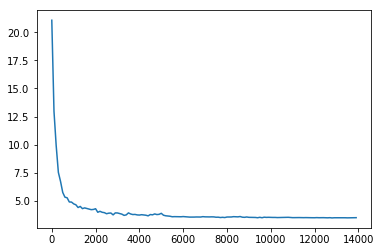

Average loss at step 14000: 1.407008 learning rate: 0.100000
Minibatch perplexity: 3.91
Validation set perplexity: 3.51


In [154]:
num_steps = 14001
summary_frequency = 100

def one_hot(arr, depth=vocab_sz):
  new = np.zeros(arr.shape + (depth,))
  new[np.arange(arr.shape[0]), arr] = 1.0
  return new

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  mean_loss = 0
  track_perplexity = []
  for step in range(num_steps):
    batches = train_batches.next()
    feed_dict = dict()
    for i in range(num_unrollings + 1):
      feed_dict[train_data[i]] = batches[i]
    _, l, predictions, lr = session.run(
      [optimizer, loss, train_prediction, learning_rate], feed_dict=feed_dict)
    mean_loss += l
    if step % summary_frequency == 0:
      if step % (summary_frequency * 10) == 0:
        # Generate some samples.
        clear_output(wait=True)
        print('=' * 80)
        for _ in range(5):
          feed = np.random.randint(0, in_vocab_sz, 1)
          sentence = rev_dic[feed[0]]
          reset_sample_state.run()
          for _ in range(79):
            prediction = sample_prediction.eval({sample_input: feed})
            new_chr = characters(sample(prediction))[0]
            sentence += new_chr
            feed = np.array([dic[sentence[-gram_sz:]]])
          print(sentence)
        print('=' * 80)
        plt.plot([summary_frequency * i for i in range(len(track_perplexity))], track_perplexity)
        plt.show()
        
      if step > 0:
        mean_loss = mean_loss / summary_frequency
      # The mean loss is an estimate of the loss over the last few batches.
      print(
        'Average loss at step %d: %f learning rate: %f' % (step, mean_loss, lr))
      mean_loss = 0
      labels = np.concatenate([one_hot(np.array([rev_chrs[rev_dic[i][-1]] for i in b])) for b in batches[1:]])
      print('Minibatch perplexity: %.2f' % float(
        np.exp(logprob(predictions, labels))))

      # Measure validation set perplexity.
      reset_sample_state.run()
      valid_logprob = 0
      for _ in range(valid_size):
        b = valid_batches.next()
        predictions = sample_prediction.eval({sample_input: b[0]})
        valid_logprob = valid_logprob + logprob(predictions, one_hot(np.array([rev_chrs[rev_dic[i][-1]] for i in b[1]])))
      valid_perplex = float(np.exp(valid_logprob / valid_size))
      print('Validation set perplexity: %.2f' % valid_perplex)
      track_perplexity.append(valid_perplex)
      

---
Problem 3
---------

(difficult!)

Write a sequence-to-sequence LSTM which mirrors all the words in a sentence. For example, if your input is:

    the quick brown fox
    
the model should attempt to output:

    eht kciuq nworb xof
    
Refer to the lecture on how to put together a sequence-to-sequence model, as well as [this article](http://arxiv.org/abs/1409.3215) for best practices.

---

In [7]:
words = text.split()
dic = set(words)

vocab = string.ascii_lowercase + ' $'
rev_vocab = { ch: i for i, ch in enumerate(vocab) }
vocab_sz = len(vocab)

def ch2id(ch):
  return rev_vocab[ch]
def id2ch(i):
  return vocab[i]

def gen_dataset(sz, max_word_len, max_sentence_len):
  filtered_dic = { w for w in dic if len(w) <= max_word_len }
  sentence_sz = max_sentence_len * (max_word_len + 1)
  data_as_ints = np.ndarray((sz, sentence_sz), dtype=np.int32)
  labels_as_ints = np.ndarray((sz, sentence_sz), dtype=np.int32)
    
  def row_from_words(ws):
    slice_len = sum([len(w) for w in rand_words]) + len(ws) - 1
    return np.array([ch2id(ch) for ch in ' '.join(ws)] + [ch2id('$')] * (sentence_sz - slice_len))

  for i in range(sz):
    sentence_len = max_sentence_len # random.randint(1, max_sentence_len)
    rand_words = random.sample(filtered_dic, sentence_len)
    
    data_as_ints[i] = row_from_words(rand_words)
    labels_as_ints[i] = row_from_words([w[::-1] for w in rand_words])
    if i % sz // 100 == 0:
      print('%d done' % (100 * i // sz))
    
  return data_as_ints, labels_as_ints

data, labels = gen_dataset(100000, max_word_len=6, max_sentence_len=5)

In [8]:
def mk_one_hot(as_ints, depth):
  rows = np.repeat(np.arange(as_ints.shape[0]), as_ints.shape[1])
  cols = np.tile(np.arange(as_ints.shape[1]), as_ints.shape[0])
  inds = as_ints.flatten()
  as_one_hot = np.zeros((as_ints.shape[0], as_ints.shape[1], depth), dtype=np.float32)
  as_one_hot[rows,cols,inds] = 1.0
  return as_one_hot

class BatchGenerator(object):
  def __init__(self, batch_sz, dataset, labels):
    self._dataset = dataset
    self._labels = labels
    self._batch_sz = batch_sz
    self._cursor = 0
  
  def _get_batch(self, data):
    return mk_one_hot(np.transpose(data[self._cursor:self._cursor + self._batch_sz]), vocab_sz)

  def next(self):
    """Generate the next array of batches from the data. The array consists of
    the last batch of the previous array, followed by num_unrollings new ones.
    """
    batch_data = self._get_batch(self._dataset)
    batch_labels = self._get_batch(self._labels)
    self._cursor = (self._cursor + self._batch_sz) % (self._dataset.shape[0] - self._cursor)
    return batch_data, batch_labels

In [9]:
data_sz = 9 * data.shape[0] // 10
valid_sz = data.shape[0] - data_sz
valid_data, valid_labels = BatchGenerator(valid_sz, data[-valid_sz:], labels[-valid_sz:]).next()


def accuracy(predictions, labels):
  slen = len(predictions.shape)
  vals = np.sum(np.equal(np.argmax(predictions, slen - 1), np.argmax(labels, slen - 1)), 1)
  num = 100.0 * np.sum(np.equal(vals, predictions.shape[1]))
  denom = np.prod(predictions.shape[0])
  return num / denom

In [52]:
num_nodes = 64
batch_sz = 16
sentence_sz = data.shape[1]
loss_coeff = 0.003
keep_prob = 0.5

graph = tf.Graph()
with graph.as_default():
  # Parameters:
  # Input gate: input, previous output, and bias.
  eW = tf.Variable(tf.truncated_normal([vocab_sz, 3 * num_nodes], -0.1, 0.1))
  eU = tf.Variable(tf.truncated_normal([num_nodes, 3 * num_nodes], -0.1, 0.1))
  eB = tf.Variable(tf.zeros([1, 3 * num_nodes]))

  dW = tf.Variable(tf.truncated_normal([num_nodes, 4 * num_nodes], -0.1, 0.1))
  dC = tf.Variable(tf.truncated_normal([num_nodes, 4 * num_nodes], -0.1, 0.1))
  dU = tf.Variable(tf.truncated_normal([num_nodes, 4 * num_nodes], -0.1, 0.1))
  dB = tf.Variable(tf.zeros([1, 4 * num_nodes]))

  # Classifier weights and biases.
  w = tf.Variable(tf.truncated_normal([2 * num_nodes, vocab_sz], -0.1, 0.1))
  b = tf.Variable(tf.zeros([vocab_sz]))

  weights = [eW, eU, dW, dC, w]

  def lstm_cell(i, o, state, x, m, b, training):
    """Create a LSTM cell. See e.g.: http://arxiv.org/pdf/1402.1128v1.pdf
    Note that in this formulation, we omit the various connections between the
    previous state and the gates."""
    def activate(thing):
      if training and False:
        return tf.nn.dropout(thing, keep_prob=keep_prob)
      return thing
    res = activate(tf.matmul(i, x)) + tf.matmul(o, m) + b
    sig_res = tf.sigmoid(res[:,:num_nodes * 3])
    state = sig_res[:,:num_nodes] * state + sig_res[:,num_nodes:num_nodes*2] * tf.tanh(res[:,num_nodes*3:])
    return activate(sig_res[:,num_nodes*2:num_nodes*3] * tf.tanh(state)), state

  # Input data.
  train_inputs = tf.placeholder(tf.float32, shape=[sentence_sz, batch_sz, vocab_sz])
  train_labels = tf.placeholder(tf.float32, shape=[sentence_sz, batch_sz, vocab_sz])

  def run_model(inputs, training=False):
    output = tf.zeros([inputs.shape[1], num_nodes])
    state = tf.zeros([inputs.shape[1], num_nodes])

    def encode_step(i, state):
      gates = tf.matmul(i, eW) + tf.matmul(state, eU) + eB
      z = tf.sigmoid(gates[:,:num_nodes])
      r = tf.sigmoid(gates[:,num_nodes:num_nodes*2])
      h_ = tf.tanh(gates[:,num_nodes*2:])

      return z * state + (1 - z) * h_
     
    _state = state
    for i in range(inputs.shape[0]):
      _state = encode_step(inputs[i], _state)
    
    outputs = []
    orig_state = _state
    _output, _state = output, state
    def decode_step(output, state):
      gates = tf.matmul(output, dW) + tf.matmul(state, dU) + tf.matmul(orig_state, dC) + dB
      f = tf.sigmoid(gates[:,:num_nodes])
      i = tf.sigmoid(gates[:,num_nodes:num_nodes*2])
      o = tf.sigmoid(gates[:,num_nodes*2:num_nodes*3])
      
      state = f * state + i * tf.tanh(gates[:,num_nodes*3:])
      output = o * state
      outputs.append(tf.concat([output, orig_state], 1))
      return output, state
    
    for _ in range(sentence_sz):
      _output, _state = decode_step(_output, _state)

    # Classifier
    return tf.nn.xw_plus_b(tf.concat(outputs, 0), w, b)
  
  logits = run_model(train_inputs, training=True)
  cross_ent = tf.nn.softmax_cross_entropy_with_logits(
        labels=train_labels, logits=logits)
  loss = tf.reduce_mean(cross_ent)
  for w in weights:
    loss = loss + loss_coeff * tf.nn.l2_loss(w)

  # Optimizer.
  global_step = tf.Variable(0)
  learning_rate = tf.train.exponential_decay(
    0.1, global_step, 5000, 0.95)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate)
  gradients, v = zip(*optimizer.compute_gradients(loss))
  gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
  optimizer = optimizer.apply_gradients(
    zip(gradients, v), global_step=global_step)

  # Predictions.
  train_prediction = tf.nn.softmax(logits)
  
  # Sampling and validation eval: batch 1, no unrolling.
  valid_inputs = tf.placeholder(tf.float32, shape=[sentence_sz, valid_sz, vocab_sz])
  valid_prediction = tf.nn.softmax(run_model(valid_inputs))

In [24]:
num_nodes = 1024
batch_sz = 32
sentence_sz = data.shape[1]
loss_coeff = 0.00
layers = 1
keep_prob = 0.5
valid_buffer_sz = 1000

graph = tf.Graph()
with graph.as_default():#, tf.device('/cpu:0'):
  # Parameters:
  # Input gate: input, previous output, and bias.
  eW = [ tf.Variable(tf.truncated_normal([dim, 4 * num_nodes], -0.1, 0.1)) for dim in [vocab_sz] + [num_nodes] * (layers - 1) ]
  eU = [ tf.Variable(tf.truncated_normal([num_nodes, 4 * num_nodes], -0.1, 0.1)) for _ in range(layers) ]
  eB = [ tf.Variable(tf.zeros([1, 4 * num_nodes])) for _ in range(layers) ]

  dW = [ tf.Variable(tf.truncated_normal([num_nodes, 4 * num_nodes], -0.1, 0.1)) for _ in range(layers) ]
  dC = [ tf.Variable(tf.truncated_normal([num_nodes, 4 * num_nodes], -0.1, 0.1)) for _ in range(layers) ]
  dU = [ tf.Variable(tf.truncated_normal([num_nodes, 4 * num_nodes], -0.1, 0.1)) for _ in range(layers) ]
  dB = [ tf.Variable(tf.zeros([1, 4 * num_nodes])) for _ in range(layers) ]

  # Classifier weights and biases.
  w = tf.Variable(tf.truncated_normal([(layers + 1) * num_nodes, vocab_sz], -0.1, 0.1))
  b = tf.Variable(tf.zeros([vocab_sz]))

  weights = eW + eU + dW + dC + dU + [w]

  def lstm_cell(i, o, state, x, m, b, training):
    """Create a LSTM cell. See e.g.: http://arxiv.org/pdf/1402.1128v1.pdf
    Note that in this formulation, we omit the various connections between the
    previous state and the gates."""
    def activate(thing):
      if training and False:
        return tf.nn.dropout(thing, keep_prob=keep_prob)
      return thing
    res = activate(tf.matmul(i, x)) + tf.matmul(o, m) + b
    sig_res = tf.sigmoid(res[:,:num_nodes * 3])
    state = sig_res[:,:num_nodes] * state + sig_res[:,num_nodes:num_nodes*2] * tf.tanh(res[:,num_nodes*3:])
    return activate(sig_res[:,num_nodes*2:num_nodes*3] * tf.tanh(state)), state

  # Input data.
  train_inputs = tf.placeholder(tf.float32, shape=[sentence_sz, batch_sz, vocab_sz])
  train_labels = tf.placeholder(tf.float32, shape=[sentence_sz, batch_sz, vocab_sz])

  def run_model(inputs, training=False):
    initial_output = tf.zeros([inputs.shape[1], num_nodes])
    initial_state = tf.zeros([inputs.shape[1], num_nodes])
    
    e_states = dict()
    e_outputs = dict()
    
    def activate(thing):
      if training:
        return tf.nn.dropout(thing, keep_prob=keep_prob)
      return thing

    def encode_layer(_inputs, j):
      outputs = []
      def encode_step(input, state):
        gates = tf.matmul(input, eW[j]) + tf.matmul(state, eU[j]) + eB[j]
        f = tf.sigmoid(gates[:,:num_nodes])
        i = tf.sigmoid(gates[:,num_nodes:num_nodes*2])
        o = tf.sigmoid(gates[:,num_nodes*2:num_nodes*3])
        
        state = f * state + i * tf.tanh(gates[:,num_nodes*3:])
        output = activate(o * state)
        return output, state
     
      _state = initial_state
      for i in range(sentence_sz):
        _output, _state = encode_step(_inputs[i], _state)
        outputs.append(_output)
        
      return _state, outputs
        
    e_outputs[-1] = inputs
    for i in range(layers):
      e_states[i], e_outputs[i] = encode_layer(e_outputs[i-1], i)
    
    d_outputs = { i: [] for i in range(-1, layers) }
    d_states = { i: [initial_state] for i in range(layers) }
    d_outputs[-1].append(initial_output)
    
    for i in range(inputs.shape[0]):
      for j in range(layers):
        def decode_step(output, state):
          gates = tf.matmul(output, dW[j]) + tf.matmul(state, dU[j]) + tf.matmul(e_states[j], dC[j]) + dB[j]
          f = tf.sigmoid(gates[:,:num_nodes])
          i = tf.sigmoid(gates[:,num_nodes:num_nodes*2])
          o = tf.sigmoid(gates[:,num_nodes*2:num_nodes*3])
      
          state = f * state + i * tf.tanh(gates[:,num_nodes*3:])
          output = activate(o * state)
          return output, state
        
        new_out, new_state = decode_step(d_outputs[j - 1][i], d_states[j][i])
        d_outputs[j].append(new_out)
        d_states[j].append(new_state)
      d_outputs[-1].append(d_outputs[layers - 1][-1])

    states_list = [ s for _, s in e_states.items() ]
    outputs = [ tf.concat([out] + states_list, 1) for out in d_outputs[layers - 1] ]
    # Classifier
    return tf.nn.xw_plus_b(tf.concat(outputs, 0), w, b)
  
  logits = run_model(train_inputs, training=True)
  cross_ent = tf.nn.softmax_cross_entropy_with_logits(
        labels=train_labels, logits=logits)
  loss = tf.reduce_mean(cross_ent)
  for w in weights:
    loss = loss + loss_coeff * tf.nn.l2_loss(w)

  # Optimizer.
  optimizer = tf.train.AdamOptimizer()
  gradients, v = zip(*optimizer.compute_gradients(loss))
  gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
  optimizer = optimizer.apply_gradients(zip(gradients, v))

  # Predictions.
  train_prediction = tf.nn.softmax(logits)
  
  # Sampling and validation eval: batch 1, no unrolling.
  valid_inputs = tf.placeholder(tf.float32, shape=[sentence_sz, valid_buffer_sz, vocab_sz])
  valid_prediction = tf.nn.softmax(run_model(valid_inputs))

In [30]:
permute = np.random.permutation(valid_sz)[:valid_buffer_sz]
b_valid_data, b_valid_labels = valid_data[:,permute,:], valid_labels[:,permute,:]
print(b_valid_data.shape)

(35, 1000, 28)


sogge aglaia dasht jitte iguchi$$$$
eggrs aialga thtad ettij ihcugi$$$$
eggos aialga thsad ettij ihcugi$$$$
fuin veram empted orhei p$$$$$$$$$$
niuf marev detpme vehro q$$$$$$$$$$
niuf marev detpme iehro p$$$$$$$$$$
moras eunice winch fevers aro$$$$$$
sarom ecinue hcniw srevef ora$$$$$$
sarom ecinue hcniw srevef ora$$$$$$
pucar dubius juice fylgdi aides$$$$
racup suibud eciub idglyf sedia$$$$
racup suibud eciuj idglyf sedia$$$$
zar fratri ikusi avini casein$$$$$$
raz irtarf isuki iniva nieeac$$$$$$
raz irtarf isuki iniva niesac$$$$$$


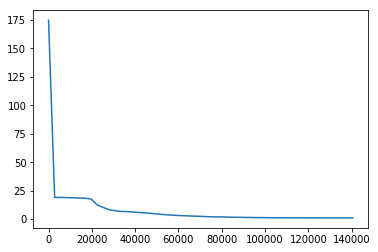

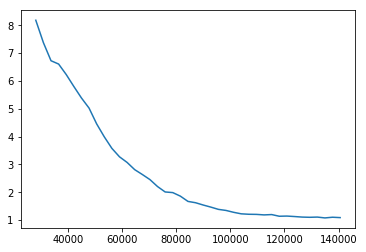

Average loss at step 140600: 0.103619
Minibatch perplexity: 1.09
Validation set perplexity: 1.0852, accuracy: 43.30
Stopped early because KeyboardInterrupt
best acc: 49.00
Wall time: 19h 36min 22s


In [32]:
%%time

num_steps = 200001
summary_frequency = data_sz // batch_sz

next_batch = BatchGenerator(batch_sz, data[:data_sz], labels[:data_sz])

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  mean_loss = 0
  track_perplexity = []
  tracc = []
  for step in range(num_steps):
    try:
      batch_data, batch_labels = next_batch.next()
      permute = np.random.permutation(valid_sz)[:valid_buffer_sz]
      b_valid_data, b_valid_labels = valid_data[:,permute,:], valid_labels[:,permute,:]
      _, l, predictions = session.run(
        [optimizer, loss, train_prediction], feed_dict={train_inputs:batch_data, train_labels:batch_labels})
      mean_loss += l
      if step % summary_frequency == 0:
        print('test')
        valid_predictions = valid_prediction.eval({valid_inputs: b_valid_data})
        print('test')
        valid_perplex = np.exp(logprob(valid_predictions, b_valid_labels))
        track_perplexity.append(valid_perplex)
        valid_acc = accuracy(valid_predictions.reshape(valid_buffer_sz, sentence_sz, vocab_sz), b_valid_labels.reshape(valid_buffer_sz, sentence_sz, vocab_sz))
        tracc.append(valid_acc)
        #if step % (summary_frequency * 10) == 0:
          # Generate some samples.
        clear_output(wait=True)
        print('=' * 80)
        def disp(i, dataset):
          row = np.argmax(dataset[:,i,:], 1)
          print(''.join([id2ch(j) for j in row.tolist()]))
        for _ in range(5):
          i = random.randint(0, valid_buffer_sz - 1)
          disp(i, b_valid_data)
          disp(i, valid_predictions.reshape(sentence_sz, valid_buffer_sz, vocab_sz))
          disp(i, b_valid_labels)
          print('=' * 80)
        #print('=' * 80)
        #for i in range(batch_data.shape[1]):
        #  disp(i, batch_data)
        #  disp(i, batch_labels)
        #  print('=' * 80)
        plt.plot([summary_frequency * i for i in range(len(track_perplexity))], track_perplexity)
        plt.show()
        drop_some = track_perplexity[len(track_perplexity) // 5:]
        plt.plot([summary_frequency * i for i in range(len(track_perplexity) - len(drop_some), len(track_perplexity))], drop_some)
        plt.show()

        if step > 0:
          mean_loss = mean_loss / summary_frequency
        # The mean loss is an estimate of the loss over the last few batches.
        print(
          'Average loss at step %d: %f' % (step, mean_loss))
        mean_loss = 0
        print('Minibatch perplexity: %.2f' % float(
          np.exp(logprob(predictions, batch_labels))))

        # Measure validation set perplexity.
        #reset_sample_state.run()

        print('Validation set perplexity: %.4f, accuracy: %.2f' % (valid_perplex, valid_acc))
    except KeyboardInterrupt:
      print('Stopped early because KeyboardInterrupt')
      break
  print('best acc: %.2f' % max(tracc))